In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from premier_league import (
    constants,
    data_extraction,
    preprocessing,
    prediction,
    visualisations,
    s3_helpers,
    mlflow_functions,
    postgres,
    expectations_helpers 
)
import joblib
from tabulate import tabulate
import runpy
import shap
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient

2023-12-12 10:01:49,621 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
import importlib
importlib.reload(prediction)
importlib.reload(visualisations)
importlib.reload(constants)
importlib.reload(data_extraction)

<module 'premier_league.data_extraction' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/data_extraction.py'>

### Load Data

In [3]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-12-12 10:01:51,877 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-12-12 10:01:52,227 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231212.json
2023-12-12 10:01:52,657 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231212.json


In [4]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION)


2023-12-12 10:01:53,193 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-12-12 10:01:53,794 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [5]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-12-12 10:01:54,038 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-12-12 10:01:54,630 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-12-12 10:01:55,244 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [6]:
full_data = data_extraction.get_fixtures(full_data)

2023-12-12 10:01:55,562 - PremierLeagueLogger - INFO - Loading data from https://fixturedownload.com/download/epl-2023-UTC.csv
2023-12-12 10:01:56,895 - PremierLeagueLogger - INFO - Loaded data from https://fixturedownload.com/download/epl-2023-UTC.csv


In [7]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-12-12 10:01:57,224 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-12-12 10:01:57,538 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231212.json
2023-12-12 10:01:58,061 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231212.json


### Preprocessing

In [8]:
transformers = s3_helpers.load_transformer_s3_pickle(
    constants.TRANSFORMER_PATH,
    is_transformer = True
)

2023-12-12 10:01:58,435 - PremierLeagueLogger - INFO - Grabbing transformer from premier-league-app/app_data/transformers/transformer_v2_20231212.pkl
2023-12-12 10:01:59,124 - PremierLeagueLogger - INFO - Loaded transformer from premier-league-app/app_data/transformers/transformer_v2_20231212.pkl


In [9]:
transformed_data = preprocessing.transform_data(
    full_data, transformers
)

2023-12-12 10:01:59,487 - PremierLeagueLogger - INFO - Transforming Data
2023-12-12 10:01:59,776 - PremierLeagueLogger - INFO - Transforming Data


### Make FTR Predictions

In [10]:
classifier = s3_helpers.load_transformer_s3_pickle(
    constants.CLASS_MODEL_NAME,
    is_transformer = False
)

2023-12-12 10:02:25,870 - PremierLeagueLogger - INFO - Grabbing transformer from premier-league-app/app_data/models/classifier_v2_20231212.pkl
2023-12-12 10:02:27,046 - PremierLeagueLogger - INFO - Loaded transformer from premier-league-app/app_data/models/classifier_v2_20231212.pkl


In [11]:
predictions = prediction.predict(transformed_data, classifier)

2023-12-12 10:02:27,366 - PremierLeagueLogger - INFO - Making Predictions


In [12]:
transformed_data['match_prediction'] = predictions

### Home Goals

In [13]:
regressor_1 = s3_helpers.load_transformer_s3_pickle(
    constants.HOME_MODEL_NAME,
    is_transformer = False
)

2023-12-12 10:02:27,695 - PremierLeagueLogger - INFO - Grabbing transformer from premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl
2023-12-12 10:02:28,574 - PremierLeagueLogger - INFO - Loaded transformer from premier-league-app/app_data/models/home_regress_model_v2_20231212.pkl


In [14]:
predictions_1 = prediction.predict(transformed_data, regressor_1)

2023-12-12 10:02:28,872 - PremierLeagueLogger - INFO - Making Predictions


In [15]:
predictions_1[0:5]

array([1, 2, 2, 2, 2])

### Away Goals

In [16]:
regressor_2 = s3_helpers.load_transformer_s3_pickle(
    constants.AWAY_MODEL_NAME,
    is_transformer = False
)

2023-12-12 10:02:29,205 - PremierLeagueLogger - INFO - Grabbing transformer from premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl
2023-12-12 10:02:30,078 - PremierLeagueLogger - INFO - Loaded transformer from premier-league-app/app_data/models/away_regress_model_v2_20231212.pkl


In [17]:
predictions_2 = prediction.predict(transformed_data, regressor_2)

2023-12-12 10:02:30,334 - PremierLeagueLogger - INFO - Making Predictions


In [18]:
predictions_2[0:10]

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Extract Current round of fixtures

In [19]:
transformed_data[transformed_data['HomeTeam'] == 'Brighton'].tail()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction
10921,2023-24,Brighton,Man City,1,33.0,38.0,28.0,18.0,1.310345,1.551724,...,0.689655,-0.241379,0.0,7,4,3,Saturday,March,16,1
10951,2023-24,Brighton,Arsenal,1,33.0,33.0,28.0,15.0,1.281250,1.593750,...,0.562500,-0.312500,0.0,7,2,5,Saturday,April,6,1
10971,2023-24,Brighton,Chelsea,1,33.0,26.0,28.0,26.0,1.264706,1.058824,...,0.000000,0.205882,0.0,7,14,-7,Saturday,April,20,0
10992,2023-24,Brighton,Aston Villa,1,33.0,35.0,28.0,20.0,1.250000,1.500000,...,0.416667,-0.250000,0.0,7,3,4,Saturday,May,4,0
11012,2023-24,Brighton,Man United,1,33.0,18.0,28.0,21.0,1.236842,1.263158,...,-0.078947,-0.026316,0.0,7,6,1,Sunday,May,19,1


In [20]:
transformed_data.head()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction
0,1995-96,Aston Villa,Man United,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,11,-9,Saturday,August,19,2
1,1995-96,Blackburn,QPR,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,15,-12,Saturday,August,19,0
2,1995-96,Chelsea,Everton,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5,7,-2,Saturday,August,19,0
3,1995-96,Liverpool,Sheffield Weds,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9,16,-7,Saturday,August,19,0
4,1995-96,Man City,Tottenham,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10,18,-8,Saturday,August,19,0


In [21]:
transformed_data['Home Prediction'] = predictions_1
transformed_data['Away Prediction'] = predictions_2
transformed_data['Result Prediction'] = transformed_data.apply(
    prediction.add_res_prediction, axis = 1)
s3_helpers.save_data_s3(transformed_data, constants.PREDICTIONS_LOCATION)

2023-12-12 10:02:30,928 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_predictions.csv


In [22]:
transformed_data['Result Prediction'].value_counts()

Result Prediction
H    6730
A    2856
D    1434
Name: count, dtype: int64

In [23]:
transformed_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction,Home Prediction,Away Prediction,Result Prediction
0,1995-96,Aston Villa,Man United,0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,11,-9,Saturday,August,19,2,1,2,A
1,1995-96,Blackburn,QPR,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,15,-12,Saturday,August,19,0,2,1,H


In [24]:
current_fixtures = data_extraction.extract_current_fixtures(
    transformed_data
)
current_fixtures.head()

2023-12-12 10:02:32,871 - PremierLeagueLogger - INFO - Attempting to read from https://fixturedownload.com/download/epl-2023-UTC.csv


,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,Home Prediction,Away Prediction,Result Prediction,Match Number,Round Number,Date,Location,Fixture Date,Fixture Time,Fixture
33,2023-24,Nott'm Forest,Tottenham,1,17.0,33.0,28.0,23.0,0.823529,1.764706,...,1,2,A,169,17,15/12/2023 20:00,The City Ground,2023-12-15,21:00,Nott'm Forest v Tottenham
34,2023-24,Bournemouth,Luton,1,21.0,17.0,30.0,32.0,1.117647,0.529412,...,2,1,H,162,17,16/12/2023 15:00,Vitality Stadium,2023-12-16,16:00,Bournemouth v Luton
35,2023-24,Chelsea,Sheffield United,1,26.0,12.0,26.0,41.0,1.117647,0.470588,...,2,1,H,165,17,16/12/2023 15:00,Stamford Bridge,2023-12-16,16:00,Chelsea v Sheffield United
36,2023-24,Man City,Crystal Palace,1,38.0,15.0,18.0,23.0,1.941176,0.941176,...,2,1,H,167,17,16/12/2023 15:00,Etihad Stadium,2023-12-16,16:00,Man City v Crystal Palace
37,2023-24,Newcastle,Fulham,1,33.0,26.0,21.0,26.0,1.529412,1.235294,...,2,1,H,168,17,16/12/2023 15:00,St. James' Park,2023-12-16,16:00,Newcastle v Fulham


### Model Performance

In [25]:
importlib.reload(mlflow_functions)

<module 'premier_league.mlflow_functions' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/mlflow_functions.py'>

In [26]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-12-12 10:02:34,295 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
2023-12-12 10:02:35,287 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
2023-12-12 10:02:35,870 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
2023-12-12 10:04:36,427 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
2023-12-12 10:06:37,120 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
2023-12-12 10:08:37,719 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': available
2023-12-12 10:08:38,085 - PremierLeagueLogger - INFO - RDS instance 'premier-league-logging' is 'available'.


In [27]:
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [28]:
client = MlflowClient()

In [29]:
print(mlflow_functions.get_all_experiments(
    client
))

[{'name': 'premier-league-experiments', 'experiment_id': '1'}, {'name': 'Default', 'experiment_id': '0'}]


In [30]:
runs = mlflow_functions.get_runs_from_experiment(
    client, experiment_id=1
)

In [31]:
run_df = mlflow_functions.runs_to_dataframe(
    mlflow_functions.get_runs_from_experiment(
    client, experiment_id=1
))

In [32]:
s3_helpers.save_data_s3(
    run_df,
    constants.MODEL_PERFORMANCE_LOCATION
)

2023-12-12 10:08:43,647 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/model_performance/model_performance_data.csv


In [33]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-12-12 10:08:44,559 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'


### Visualisations

In [34]:
table = current_fixtures[['Fixture Date', 'Fixture Time', 'Location', 'HomeTeam', 'AwayTeam', 
                  'Home Prediction', 'Away Prediction' ,'Result Prediction']].reset_index(drop=True)
print(tabulate(table, tablefmt='fancy_grid', headers='keys'))

╒════╤═════════════════════╤════════════════╤═════════════════════════╤════════════════╤══════════════════╤═══════════════════╤═══════════════════╤═════════════════════╕
│    │ Fixture Date        │ Fixture Time   │ Location                │ HomeTeam       │ AwayTeam         │   Home Prediction │   Away Prediction │ Result Prediction   │
╞════╪═════════════════════╪════════════════╪═════════════════════════╪════════════════╪══════════════════╪═══════════════════╪═══════════════════╪═════════════════════╡
│  0 │ 2023-12-15 00:00:00 │ 21:00          │ The City Ground         │ Nott'm Forest  │ Tottenham        │                 1 │                 2 │ A                   │
├────┼─────────────────────┼────────────────┼─────────────────────────┼────────────────┼──────────────────┼───────────────────┼───────────────────┼─────────────────────┤
│  1 │ 2023-12-16 00:00:00 │ 16:00          │ Vitality Stadium        │ Bournemouth    │ Luton            │                 2 │                 1 │ H 

In [35]:
table = current_fixtures[['HomeTeam', 'AwayTeam', 
                  'Home Prediction', 'Away Prediction']].reset_index(drop=True)
table.index = table.index + 1
print(tabulate(table, tablefmt='fancy_grid', headers='keys'))

╒════╤════════════════╤══════════════════╤═══════════════════╤═══════════════════╕
│    │ HomeTeam       │ AwayTeam         │   Home Prediction │   Away Prediction │
╞════╪════════════════╪══════════════════╪═══════════════════╪═══════════════════╡
│  1 │ Nott'm Forest  │ Tottenham        │                 1 │                 2 │
├────┼────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  2 │ Bournemouth    │ Luton            │                 2 │                 1 │
├────┼────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  3 │ Chelsea        │ Sheffield United │                 2 │                 1 │
├────┼────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  4 │ Man City       │ Crystal Palace   │                 2 │                 1 │
├────┼────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  5 │ Newcastle      │ Fulham           │                 2 │                 1 │
├───

In [36]:
# Example of extract last 5
#importlib.reload(visualisations)
results = visualisations.extract_last_results('Brentford', transformed_data)

Brentford
╒════════════════╕
│ Last 5 Games   │
╞════════════════╡
│ D              │
├────────────────┤
│ D              │
├────────────────┤
│ D              │
├────────────────┤
│ D              │
├────────────────┤
│ D              │
╘════════════════╛


In [37]:
classifier

In [38]:
transformed_data.head()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction,Home Prediction,Away Prediction,Result Prediction
0,1995-96,Aston Villa,Man United,0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,11,-9,Saturday,August,19,2,1,2,A
1,1995-96,Blackburn,QPR,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,15,-12,Saturday,August,19,0,2,1,H
2,1995-96,Chelsea,Everton,1,0.0,0.0,0.0,0.0,0.0,0.0,...,5,7,-2,Saturday,August,19,0,2,1,H
3,1995-96,Liverpool,Sheffield Weds,0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,16,-7,Saturday,August,19,0,2,1,H
4,1995-96,Man City,Tottenham,1,0.0,0.0,0.0,0.0,0.0,0.0,...,10,18,-8,Saturday,August,19,0,2,1,H


In [39]:
# Shap values
explainer = shap.TreeExplainer(regressor_1)
shap_values = explainer.shap_values(transformed_data[regressor_1.feature_names_])

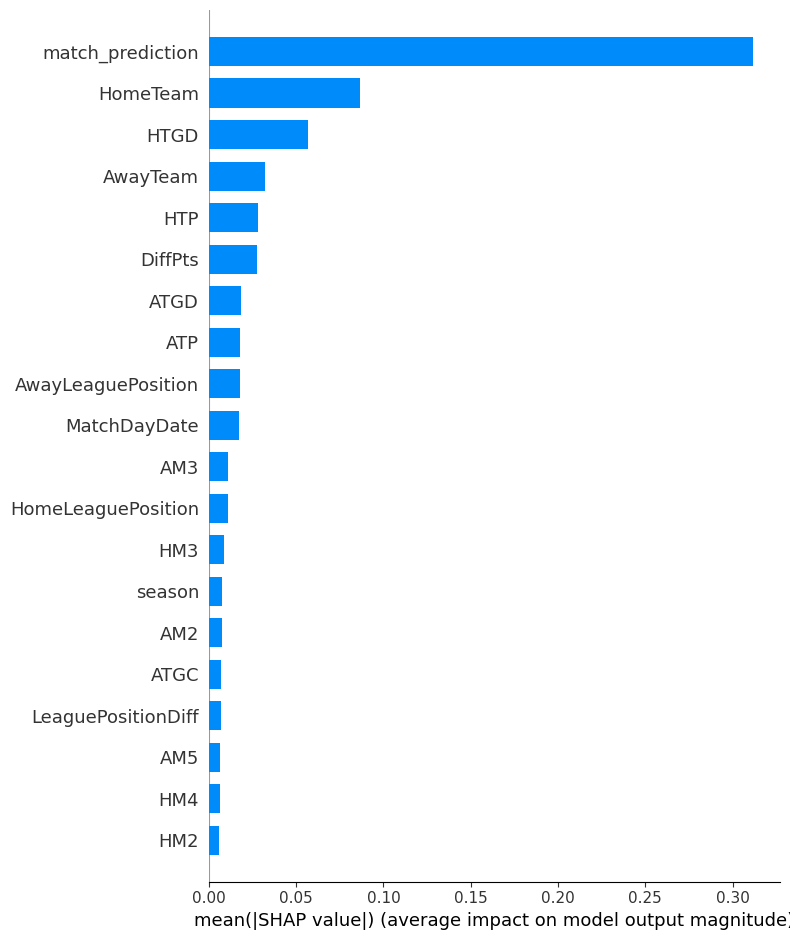

In [40]:
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_1.feature_names_],
        plot_type = 'bar'
)

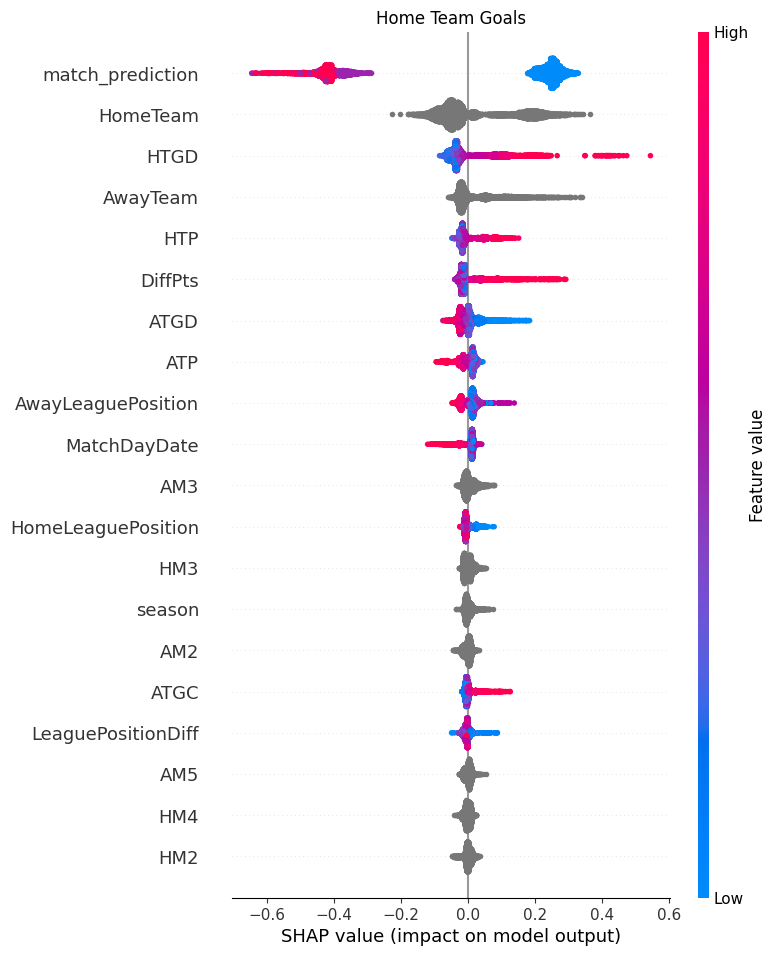

In [41]:
# Loop through each class and create a summary plot
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_1.feature_names_], 
        show=False
)
plt.title('Home Team Goals')
plt.show()

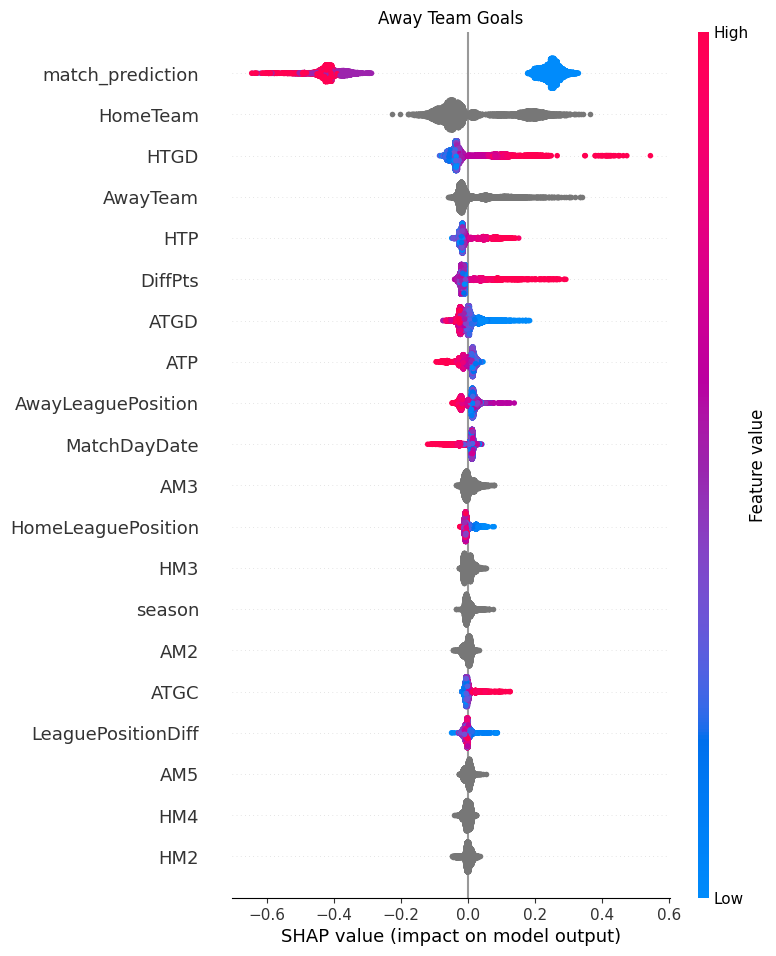

In [42]:
# Loop through each class and create a summary plot
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_2.feature_names_], 
        show=False
)
plt.title('Away Team Goals')
plt.show()

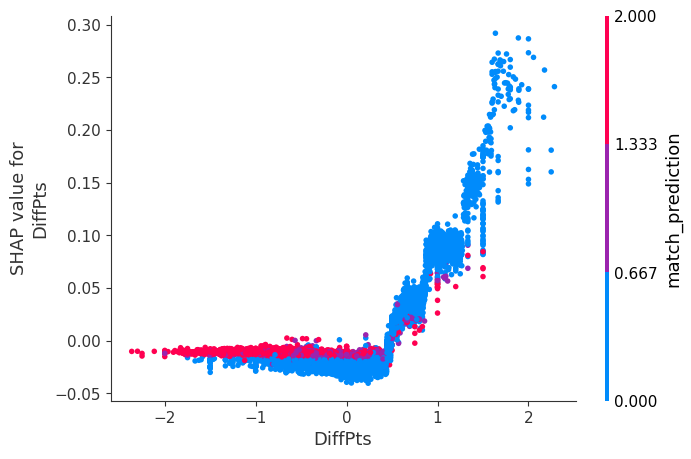

In [43]:
shap.dependence_plot(
    'DiffPts', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)

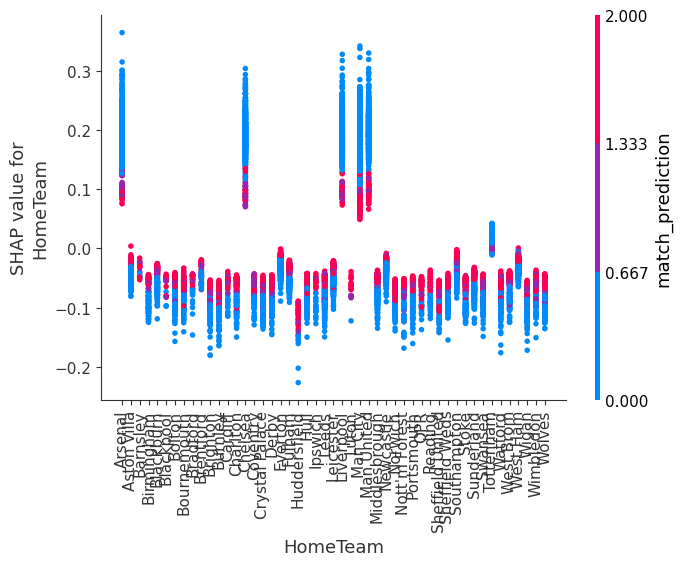

In [44]:
shap.dependence_plot(
    'HomeTeam', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)

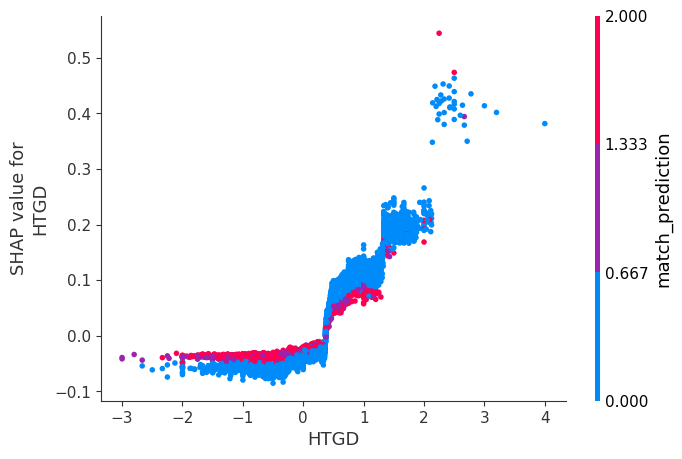

In [45]:
shap.dependence_plot(
    'HTGD', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)